# Keypoint Model Comparison

This notebook benchmarks every trained keypoint model saved in `models/keypoint` against the landmark dataset `data/keypoint.csv` built from MediaPipe hand gestures.

The workflow loads all `.tflite` and `.joblib` checkpoints (others can be added easily) and reports:

- Accuracy, macro F1, per-class precision/recall/F1 and the full classification report.
- Top-k accuracy, inference latency / throughput, disk size, estimated parameter count and training time.
- Robustness to additive landmark noise.
- Confusion matrix visualizations, McNemar's statistical significance test and a focused analysis of the similar gestures **Pinch (8)**, **OK (3)** and **Love (9)**.

Adjust the configuration cell below if you want to point at a different dataset, tweak the noise magnitude or provide known training times.


*ENSURE all models are trained using the same dataset*

In [25]:

import csv
import datetime
import re
import time
from itertools import count
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import joblib
import tensorflow as tf

from scipy.stats import chi2
from sklearn.base import clone
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_fscore_support,
    top_k_accuracy_score,
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier

np.set_printoptions(linewidth=140, suppress=True)
pd.set_option("display.max_colwidth", None)

def find_repo_root(start: Path) -> Path:
    for candidate in [start, *start.parents]:
        if (candidate / "data").is_dir() and (candidate / "models").is_dir():
            return candidate
    raise RuntimeError("Could not locate the project root (data/ and models/ folders not found).")

REPO_ROOT = find_repo_root(Path.cwd())
DATA_FILE = REPO_ROOT / "data" / "keypoint.csv"
LABELS_FILE = REPO_ROOT / "data" / "keypoint_labels.csv"
MODEL_DIR = REPO_ROOT / "models" / "keypoint"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

TOP_K = 3
TOP_K_KEY = f"top_{TOP_K}_accuracy"
NOISE_STD = 0.015
RANDOM_SEED = 42
SIMILAR_GESTURE_GROUP = [3, 8, 9]  # OK, Pinch, Love
SIMILAR_ANCHOR = 8                 # Pinch is our anchor class

# Optional overrides for training time measurements (seconds)
TRAINING_TIME_OVERRIDES = {
    # "joblib::keypoint_classifier_LogisticRegression.joblib": 12.4,
    # "tflite::keypoint_classifier.tflite": 480.0,
}

TRAIN_MODELS = True
TEST_SIZE = 0.25

TRAINED_JOBLIB_MODELS = []
TRAINED_TFLITE_MODELS = []
TRAINING_RUN_RECORDS = []
ARTIFACT_COUNTER = count()

rng = np.random.default_rng(RANDOM_SEED)

JOBLIB_MODELS = []
TFLITE_MODELS = []

print(f"TensorFlow version: {tf.__version__}")
print(f"Repo root: {REPO_ROOT}")
print(f"Dataset: {DATA_FILE}")
print(f"Models directory: {MODEL_DIR}")
print(f"Training enabled: {TRAIN_MODELS}")


TensorFlow version: 2.19.1
Repo root: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition
Dataset: c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\data\keypoint.csv
Detected 7 joblib models and 2 TFLite models.


In [26]:
def load_label_map(path: Path):
    mapping = {}
    with path.open(encoding="utf-8-sig") as f:
        reader = csv.reader(f)
        for idx, row in enumerate(reader):
            if not row:
                continue
            raw = row[0].strip()
            digits = "".join(ch for ch in raw if ch.isdigit())
            label_id = int(digits) if digits else idx
            label_name = raw[: len(raw) - len(digits)] or raw
            mapping[label_id] = label_name
    return mapping

label_map = load_label_map(LABELS_FILE)
label_ids_sorted = sorted(label_map.keys())
label_names_sorted = [label_map[i] for i in label_ids_sorted]

df = pd.read_csv(DATA_FILE, header=None)
print(f"Dataset shape: {df.shape} (rows x columns)")
display(df.head())

X = df.iloc[:, 1:].to_numpy(dtype=np.float32)
y = df.iloc[:, 0].astype(int).to_numpy()

X_noise = (X + rng.normal(loc=0.0, scale=NOISE_STD, size=X.shape)).astype(np.float32)

print(f"Feature matrix: {X.shape}, Labels: {y.shape}, Unique classes: {sorted(np.unique(y))}")
print(f"Noise std applied to landmarks: {NOISE_STD}")


Dataset shape: (1267, 43) (rows x columns)


,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0,0.0,0.0,-0.401961,-0.147059,-0.686275,-0.333333,-0.872549,-0.480392,-1.000000,...,0.539216,-0.862745,0.421569,-0.401961,0.598039,-0.519608,0.715686,-0.568627,0.813725,-0.617647
1,0,0.0,0.0,-0.411765,-0.137255,-0.696078,-0.323529,-0.872549,-0.460784,-1.000000,...,0.549020,-0.852941,0.431373,-0.401961,0.598039,-0.509804,0.715686,-0.549020,0.803922,-0.588235
2,0,0.0,0.0,-0.392857,-0.160714,-0.660714,-0.321429,-0.821429,-0.446429,-0.928571,...,0.491071,-0.928571,0.401786,-0.446429,0.544643,-0.571429,0.633929,-0.616071,0.714286,-0.651786
3,0,0.0,0.0,-0.376068,-0.119658,-0.623932,-0.273504,-0.769231,-0.401709,-0.897436,...,0.504274,-0.931624,0.401709,-0.427350,0.555556,-0.547009,0.641026,-0.598291,0.726496,-0.641026
4,0,0.0,0.0,-0.303448,-0.110345,-0.503448,-0.275862,-0.634483,-0.413793,-0.744828,...,0.420690,-0.937931,0.331034,-0.427586,0.468966,-0.537931,0.551724,-0.606897,0.641379,-0.675862


Feature matrix: (1267, 42), Labels: (1267,), Unique classes: [0, 1, 2, 3, 4, 5]
Noise std applied to landmarks: 0.015


In [ ]:

NUM_FEATURES = X.shape[1]
FEATURES_PER_LANDMARK = 2
NUM_LANDMARKS = NUM_FEATURES // FEATURES_PER_LANDMARK
NUM_CLASSES = len(label_ids_sorted)

X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_SEED,
    stratify=y,
)

print(f"Train split: {X_train_split.shape}, Validation split: {X_val_split.shape}")
print(f"Class distribution (train): {np.bincount(y_train_split, minlength=NUM_CLASSES)}")
print(f"Class distribution (val):   {np.bincount(y_val_split, minlength=NUM_CLASSES)}")



## Unified Training Pipelines

The next cells consolidate the end-to-end training flows from the dedicated notebooks:

- `keypoint_training.ipynb` (MLP baseline)
- `keypoint_training_baseline.ipynb` (classical scikit-learn baselines)
- `keypoint_training_gesture_transformer.ipynb` (graph-aware Transformer)
- `keypoint_training_transformer_self_attention.ipynb` (Transformer self-attention)
- `keypoint_training_xboost.ipynb` (XGBoost)

Running this section retrains every model variant, saves the resulting checkpoints inside `models/keypoint`, and records metrics so the comparison stage can immediately benchmark the fresh outputs.


In [ ]:

def slugify_name(name: str) -> str:
    slug = re.sub(r"[^0-9a-zA-Z]+", "_", name).strip("_").lower()
    return slug or "model"

def next_artifact_suffix() -> str:
    return f"{datetime.datetime.now().strftime('%Y%m%d_%H%M%S')}_{next(ARTIFACT_COUNTER):02d}"

def log_training_record(model_name, artifact_type, artifact_path, train_time, metrics=None):
    record = {
        "model_name": model_name,
        "artifact_type": artifact_type,
        "artifact_path": str(artifact_path),
        "train_time_s": float(train_time),
    }
    if metrics:
        record.update(metrics)
    TRAINING_RUN_RECORDS.append(record)


def register_joblib_model(display_name, alias, estimator, train_time, metrics=None):
    slug = slugify_name(alias or display_name)
    suffix = next_artifact_suffix()
    path = MODEL_DIR / f"keypoint_classifier_{slug}_{suffix}.joblib"
    joblib.dump(estimator, path)
    TRAINED_JOBLIB_MODELS.append(path)
    TRAINING_TIME_OVERRIDES[f"joblib::{path.name}"] = float(train_time)
    log_training_record(display_name, "joblib", path, train_time, metrics)
    return path


def register_tflite_model(display_name, alias, keras_model, train_time, metrics=None, quantize=True):
    slug = slugify_name(alias or display_name)
    suffix = next_artifact_suffix()
    keras_path = MODEL_DIR / f"keypoint_classifier_{slug}_{suffix}.keras"
    keras_model.save(keras_path, include_optimizer=False)

    converter = tf.lite.TFLiteConverter.from_keras_model(keras_model)
    if quantize:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_buffer = converter.convert()

    tflite_path = MODEL_DIR / f"keypoint_classifier_{slug}_{suffix}.tflite"
    with tflite_path.open("wb") as f:
        f.write(tflite_buffer)
    TRAINED_TFLITE_MODELS.append(tflite_path)
    TRAINING_TIME_OVERRIDES[f"tflite::{tflite_path.name}"] = float(train_time)
    log_training_record(display_name, "tflite", tflite_path, train_time, metrics)
    return keras_path, tflite_path


def evaluate_split_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")
    return acc, macro_f1


def reset_tf_session():
    tf.keras.backend.clear_session()


In [ ]:

def train_classical_baselines(X_train, y_train, X_val, y_val):
    print("
🧠 Training classical ML baselines...")
    models = {
        "LinearSVC": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LinearSVC(
                C=1.0,
                loss="squared_hinge",
                random_state=RANDOM_SEED,
                dual=False,
            )),
        ]),
        "LogisticRegression": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", LogisticRegression(
                multi_class="multinomial",
                solver="lbfgs",
                max_iter=1000,
                random_state=RANDOM_SEED,
            )),
        ]),
        "KNeighbors": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", KNeighborsClassifier(
                n_neighbors=5,
                weights="distance",
                metric="minkowski",
            )),
        ]),
        "SVC_RBF": Pipeline([
            ("scaler", StandardScaler()),
            ("clf", SVC(
                kernel="rbf",
                C=10.0,
                gamma="scale",
                probability=True,
                random_state=RANDOM_SEED,
            )),
        ]),
        "RandomForest": RandomForestClassifier(
            n_estimators=300,
            max_depth=None,
            random_state=RANDOM_SEED,
            n_jobs=-1,
        ),
    }

    artifacts = []
    for name, estimator in models.items():
        start = time.perf_counter()
        estimator.fit(X_train, y_train)
        duration = time.perf_counter() - start
        y_pred = estimator.predict(X_val)
        acc, macro_f1 = evaluate_split_metrics(y_val, y_pred)
        metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
        path = register_joblib_model(f"Baseline::{name}", name, estimator, duration, metrics)
        print(f"  {name:15s} | acc={acc:.4f} macro F1={macro_f1:.4f} | saved→{path.name}")
        artifacts.append((name, path))
    return artifacts


In [ ]:

def build_mlp_baseline(input_dim, num_classes):
    return tf.keras.Sequential([
        tf.keras.layers.Input((input_dim,)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(20, activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(10, activation="relu"),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(num_classes, activation="softmax"),
    ], name="mlp_keypoint_classifier")


def train_mlp_classifier(X_train, y_train, X_val, y_val):
    print("
🤖 Training MLP baseline (Keras)...")
    reset_tf_session()
    model = build_mlp_baseline(X_train.shape[1], NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
    ]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32),
        y_train,
        epochs=1000,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    keras_path, tflite_path = register_tflite_model("MLP", "mlp", model, duration, metrics)
    print(f"  MLP validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return keras_path, tflite_path


In [ ]:

HAND_CONNECTIONS = [
    (0, 1), (1, 2), (2, 3), (3, 4),
    (0, 5), (5, 6), (6, 7), (7, 8),
    (0, 9), (9, 10), (10, 11), (11, 12),
    (0, 13), (13, 14), (14, 15), (15, 16),
    (0, 17), (17, 18), (18, 19), (19, 20),
]


def build_adjacency_matrix(num_nodes, connections):
    adj = np.zeros((num_nodes, num_nodes), dtype=np.float32)
    for i, j in connections:
        adj[i, j] = 1.0
        adj[j, i] = 1.0
    np.fill_diagonal(adj, 1.0)
    return adj

GRAPH_ADJ = build_adjacency_matrix(NUM_LANDMARKS, HAND_CONNECTIONS)


class GraphAttentionLayer(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, adjacency_matrix, **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)
        self._adjacency_matrix_for_config = adjacency_matrix
        self.adj = tf.constant(adjacency_matrix, dtype=tf.float32)
        self.graph_bias_weight = self.add_weight(
            name="graph_bias_weight",
            shape=(),
            initializer="zeros",
            trainable=True,
        )

    def call(self, x):
        bias = self.adj * self.graph_bias_weight
        bias = tf.expand_dims(bias, axis=0)
        bias = tf.expand_dims(bias, axis=1)
        return self.mha(x, x, attention_mask=bias)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
            "adjacency_matrix": self._adjacency_matrix_for_config.tolist(),
        })
        return config

    @classmethod
    def from_config(cls, config):
        config["adjacency_matrix"] = np.array(config["adjacency_matrix"], dtype=np.float32)
        return cls(**config)


def build_graph_transformer(adjacency_matrix, num_joints, joint_dim, num_classes,
                            d_model=64, num_heads=4, ff_multiplier=2, num_layers=2,
                            dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(num_joints * joint_dim,), name="flat_input")
    x = tf.keras.layers.Reshape((num_joints, joint_dim), name="reshape_tokens")(inputs)
    x = tf.keras.layers.Dense(d_model, name="token_projection")(x)
    joint_ids = tf.range(num_joints)
    joint_emb = tf.keras.layers.Embedding(input_dim=num_joints, output_dim=d_model)(joint_ids)
    x = tf.keras.layers.Add(name="add_joint_id")([x, tf.expand_dims(joint_emb, axis=0)])

    for idx in range(num_layers):
        res = x
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln1_{idx}")(x)
        x = GraphAttentionLayer(num_heads=num_heads,
                                key_dim=d_model // num_heads,
                                adjacency_matrix=adjacency_matrix,
                                name=f"graph_attn_{idx}")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Add(name=f"res1_{idx}")([res, x])

        res = x
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6, name=f"ln2_{idx}")(x)
        x = tf.keras.layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        x = tf.keras.layers.Dense(d_model)(x)
        x = tf.keras.layers.Add(name=f"res2_{idx}")([res, x])

    pooled = tf.keras.layers.GlobalAveragePooling1D(name="gap")(x)
    pooled = tf.keras.layers.Dropout(dropout_rate)(pooled)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="classification_head")(pooled)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="GraphTransformer")


def train_graph_transformer(X_train, y_train, X_val, y_val):
    print("
🕸️ Training graph-aware Transformer...")
    reset_tf_session()
    model = build_graph_transformer(GRAPH_ADJ, NUM_LANDMARKS, FEATURES_PER_LANDMARK, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32), y_train,
        epochs=200,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    _, tflite_path = register_tflite_model("GraphTransformer", "graph_transformer", model, duration, metrics)
    print(f"  Graph Transformer validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return tflite_path


In [ ]:

def build_transformer_classifier(num_joints, joint_dim, num_classes,
                                 d_model=64, num_heads=4, ff_multiplier=2,
                                 num_layers=2, dropout_rate=0.1):
    inputs = tf.keras.Input(shape=(num_joints * joint_dim,))
    x = tf.keras.layers.Reshape((num_joints, joint_dim))(inputs)
    x = tf.keras.layers.Dense(d_model)(x)

    for _ in range(num_layers):
        attn = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = tf.keras.layers.Add()([x, attn])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

        ff = tf.keras.layers.Dense(d_model * ff_multiplier, activation="relu")(x)
        ff = tf.keras.layers.Dense(d_model)(ff)
        ff = tf.keras.layers.Dropout(dropout_rate)(ff)
        x = tf.keras.layers.Add()([x, ff])
        x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(x)

    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs, name="transformer_self_attention")


def train_self_attention_transformer(X_train, y_train, X_val, y_val):
    print("
⚡ Training Transformer self-attention model...")
    reset_tf_session()
    model = build_transformer_classifier(NUM_LANDMARKS, FEATURES_PER_LANDMARK, NUM_CLASSES)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    callbacks = [tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True, verbose=1)]
    start = time.perf_counter()
    model.fit(
        X_train.astype(np.float32), y_train,
        epochs=170,
        batch_size=128,
        validation_data=(X_val.astype(np.float32), y_val),
        callbacks=callbacks,
        verbose=1,
    )
    duration = time.perf_counter() - start
    preds = np.argmax(model.predict(X_val.astype(np.float32), verbose=0), axis=1)
    acc, macro_f1 = evaluate_split_metrics(y_val, preds)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    _, tflite_path = register_tflite_model("TransformerSelfAttention", "transformer_self_attention", model, duration, metrics)
    print(f"  Transformer validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{tflite_path.name}")
    return tflite_path


In [ ]:

def train_xgboost_classifier(X_train, y_train, X_val, y_val):
    print("
🌲 Training XGBoost classifier with grid search...")
    num_classes = len(np.unique(y_train))
    base_params = dict(
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=RANDOM_SEED,
        n_jobs=-1,
    )
    param_grid = {
        "max_depth": [2, 4],
        "n_estimators": [100, 200],
        "learning_rate": [0.05, 0.1],
    }
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_SEED)
    estimator = XGBClassifier(**base_params)
    grid = GridSearchCV(
        estimator=estimator,
        param_grid=param_grid,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=1,
    )
    start = time.perf_counter()
    grid.fit(X_train, y_train)
    duration = time.perf_counter() - start
    best_model = grid.best_estimator_
    print(f"  Best params: {grid.best_params_} | CV accuracy={grid.best_score_:.4f}")
    y_pred = best_model.predict(X_val)
    acc, macro_f1 = evaluate_split_metrics(y_val, y_pred)
    metrics = {"val_accuracy": acc, "val_macro_f1": macro_f1}
    path = register_joblib_model("XGBoost", "xgboost", best_model, duration, metrics)
    print(f"  XGBoost validation accuracy={acc:.4f}, macro F1={macro_f1:.4f} | saved→{path.name}")
    return path


In [ ]:

if TRAIN_MODELS:
    TRAINED_JOBLIB_MODELS.clear()
    TRAINED_TFLITE_MODELS.clear()
    TRAINING_RUN_RECORDS.clear()

    baseline_artifacts = train_classical_baselines(X_train_split, y_train_split, X_val_split, y_val_split)
    mlp_artifacts = train_mlp_classifier(X_train_split, y_train_split, X_val_split, y_val_split)
    graph_artifact = train_graph_transformer(X_train_split, y_train_split, X_val_split, y_val_split)
    self_attn_artifact = train_self_attention_transformer(X_train_split, y_train_split, X_val_split, y_val_split)
    xgb_artifact = train_xgboost_classifier(X_train_split, y_train_split, X_val_split, y_val_split)

    print("
✅ Finished training all model families.")
else:
    print("Training disabled via TRAIN_MODELS flag – skipping model retraining.")


In [ ]:

if TRAINING_RUN_RECORDS:
    training_df = pd.DataFrame(TRAINING_RUN_RECORDS)
    display(training_df.sort_values(by=["val_macro_f1", "val_accuracy"], ascending=False, na_position="last"))
else:
    print("No new training records captured in this session.")


In [ ]:

if TRAINED_JOBLIB_MODELS or TRAINED_TFLITE_MODELS:
    JOBLIB_MODELS = TRAINED_JOBLIB_MODELS
    TFLITE_MODELS = TRAINED_TFLITE_MODELS
else:
    JOBLIB_MODELS = sorted(MODEL_DIR.glob("*.joblib"))
    TFLITE_MODELS = sorted(MODEL_DIR.glob("*.tflite"))

print(f"Detected {len(JOBLIB_MODELS)} joblib models and {len(TFLITE_MODELS)} TFLite models for evaluation.")


In [27]:
def describe_label(label_id):
    return f"{label_id}: {label_map.get(label_id, str(label_id))}"

def format_labels(label_ids):
    return [describe_label(idx) for idx in label_ids]

def compute_custom_metrics(y_true, y_pred, similar_group, anchor_class):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    mask_anchor = y_true == anchor_class
    if mask_anchor.any():
        other_ids = [c for c in similar_group if c != anchor_class]
        frac_anchor_as_others = np.mean(np.isin(y_pred[mask_anchor], other_ids))
    else:
        frac_anchor_as_others = np.nan

    relaxed_correct = []
    for t, p in zip(y_true, y_pred):
        if t in similar_group:
            relaxed_correct.append(p in similar_group)
        else:
            relaxed_correct.append(p == t)
    relaxed_accuracy = float(np.mean(relaxed_correct))
    return frac_anchor_as_others, relaxed_accuracy

def mcnemars_test(y_true, y_pred_a, y_pred_b):
    y_true = np.asarray(y_true)
    y_pred_a = np.asarray(y_pred_a)
    y_pred_b = np.asarray(y_pred_b)

    correct_a = y_pred_a == y_true
    correct_b = y_pred_b == y_true

    b = np.sum(correct_a & ~correct_b)
    c = np.sum(~correct_a & correct_b)
    n = b + c
    if n == 0:
        return np.nan, np.nan, b, c

    chi2_stat = (abs(b - c) - 1) ** 2 / n
    p_value = chi2.sf(chi2_stat, df=1)
    return chi2_stat, p_value, b, c

def plot_confusion_matrix(cm, label_strings, title="Confusion Matrix"):
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cm, cmap="Blues")
    ax.set_xticks(range(len(label_strings)))
    ax.set_yticks(range(len(label_strings)))
    ax.set_xticklabels(label_strings, rotation=45, ha="right")
    ax.set_yticklabels(label_strings)
    ax.set_ylabel("True label")
    ax.set_xlabel("Predicted label")
    ax.set_title(title)

    thresh = cm.max() / 2.0 if cm.any() else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                cm[i, j],
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )
    fig.colorbar(im, ax=ax)
    fig.tight_layout()
    plt.show()

def plot_two_confusion_matrices(cm_a, labels_a, name_a, cm_b, labels_b, name_b):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, cm, labels, title in zip(
        axes,
        [cm_a, cm_b],
        [labels_a, labels_b],
        [name_a, name_b],
    ):
        im = ax.imshow(cm, cmap="Blues")
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha="right")
        ax.set_yticklabels(labels)
        ax.set_ylabel("True label")
        ax.set_xlabel("Predicted label")
        ax.set_title(title)
        thresh = cm.max() / 2.0 if cm.any() else 0
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(
                    j,
                    i,
                    cm[i, j],
                    ha="center",
                    va="center",
                    color="white" if cm[i, j] > thresh else "black",
                )
    fig.colorbar(im, ax=axes.ravel().tolist())
    fig.tight_layout()
    plt.show()

def estimate_parameter_count(model):
    seen = set()
    total = 0
    stack = [model]
    while stack:
        obj = stack.pop()
        if obj is None:
            continue
        obj_id = id(obj)
        if obj_id in seen:
            continue
        seen.add(obj_id)

        if isinstance(obj, np.ndarray):
            total += obj.size
            continue
        if isinstance(obj, (list, tuple, set)):
            stack.extend(obj)
            continue
        if isinstance(obj, dict):
            stack.extend(obj.values())
            continue

        for attr in (
            "coef_",
            "intercept_",
            "support_vectors_",
            "dual_coef_",
            "rho_",
            "feature_importances_",
            "estimators_",
            "tree_",
            "value",
        ):
            if hasattr(obj, attr):
                stack.append(getattr(obj, attr))

        if hasattr(obj, "__dict__"):
            stack.extend(obj.__dict__.values())
    return int(total) if total else np.nan

def measure_joblib_training_time(model, X_train, y_train):
    try:
        estimator = clone(model)
    except Exception:
        return np.nan, "clone_failed"

    start = time.perf_counter()
    try:
        estimator.fit(X_train, y_train)
    except Exception:
        return np.nan, "fit_failed"
    elapsed = time.perf_counter() - start
    return float(elapsed), "measured_fit"


In [28]:
def safe_top_k_accuracy(y_true, score_matrix, score_labels, k):
    if score_matrix is None or score_labels is None:
        return np.nan
    score_labels = np.asarray(score_labels)
    if score_matrix.shape[1] != len(score_labels):
        return np.nan
    y_true = np.asarray(y_true)
    mask = np.isin(y_true, score_labels)
    if not np.any(mask):
        return np.nan
    filtered_scores = score_matrix[mask]
    filtered_true = y_true[mask]
    return top_k_accuracy_score(filtered_true, filtered_scores, k=k, labels=score_labels)

def get_joblib_scores(model, X_data, y_true, labels, top_k):
    start = time.perf_counter()
    y_pred = model.predict(X_data)
    elapsed = time.perf_counter() - start
    latency_ms = (elapsed / len(X_data)) * 1000.0
    samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf

    y_proba = None
    proba_labels = None
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_data)
        proba_labels = getattr(model, "classes_", None)
    elif hasattr(model, "decision_function"):
        scores = model.decision_function(X_data)
        scores = np.asarray(scores)
        if scores.ndim == 1:
            scores = np.vstack([-scores, scores]).T
        exp_scores = np.exp(scores - scores.max(axis=1, keepdims=True))
        y_proba = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        proba_labels = getattr(model, "classes_", None)

    topk_acc = safe_top_k_accuracy(y_true, y_proba, proba_labels, top_k)
    return y_pred, y_proba, topk_acc, latency_ms, samples_per_second

def evaluate_joblib_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"joblib::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    model = joblib.load(model_path)

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    y_pred, y_proba, topk_acc, latency_ms, sps = get_joblib_scores(
        model, X_eval, y_eval, labels, TOP_K
    )
    y_pred_noise, _, _, _, _ = get_joblib_scores(
        model, X_eval_noise, y_eval, labels, TOP_K
    )

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    frac_anchor_to_others, relaxed_acc = compute_custom_metrics(
        y_eval, y_pred, SIMILAR_GESTURE_GROUP, SIMILAR_ANCHOR
    )

    model_disk_mb = model_path.stat().st_size / (1024**2)
    param_count = estimate_parameter_count(model)

    training_time_s, training_time_source = measure_joblib_training_time(model, X, y)
    if np.isnan(training_time_s):
        training_time_s = TRAINING_TIME_OVERRIDES.get(name, np.nan)
        if not np.isnan(training_time_s):
            training_time_source = "override"

    result = {
        "model_name": name,
        "model_type": "joblib",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        "relaxed_acc_group": relaxed_acc,
        f"frac_true_{SIMILAR_ANCHOR}_as_others_in_group": frac_anchor_to_others,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"
    param_display = "N/A" if np.isnan(param_count) else f"{int(param_count):,}"
    frac_display = "N/A" if np.isnan(frac_anchor_to_others) else f"{frac_anchor_to_others:.4f}"

    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB | Parameters≈{param_display}")
    print(f"  Noise ({NOISE_STD} σ) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    print(f"  Similar gestures relaxed acc={relaxed_acc:.4f}, Pinch→(OK/Love) frac={frac_display}")

    return name, result

def evaluate_tflite_model(model_path, X_eval, X_eval_noise, y_eval):
    name = f"tflite::{model_path.name}"
    print("")
    print(f"📦 Evaluating {name}")
    interpreter = tf.lite.Interpreter(model_path=str(model_path))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]
    input_index = input_details["index"]
    output_index = output_details["index"]
    input_dtype = input_details["dtype"]

    def run_inference(X_data):
        preds = []
        outputs = []
        start = time.perf_counter()
        for row in X_data:
            tensor = np.expand_dims(row, axis=0).astype(input_dtype)
            interpreter.set_tensor(input_index, tensor)
            interpreter.invoke()
            out = interpreter.get_tensor(output_index)
            outputs.append(out[0])
            preds.append(int(np.argmax(out)))
        elapsed = time.perf_counter() - start
        latency_ms = (elapsed / len(X_data)) * 1000.0
        samples_per_second = len(X_data) / elapsed if elapsed > 0 else np.inf
        outputs = np.asarray(outputs, dtype=np.float32)
        exp_scores = np.exp(outputs - outputs.max(axis=1, keepdims=True))
        probs = exp_scores / exp_scores.sum(axis=1, keepdims=True)
        return np.array(preds), probs, latency_ms, samples_per_second

    y_pred, y_proba, latency_ms, sps = run_inference(X_eval)
    y_pred_noise, _, _, _ = run_inference(X_eval_noise)

    labels = np.array(sorted(np.unique(y_eval)))
    label_strings = format_labels(labels)

    acc = accuracy_score(y_eval, y_pred)
    macro_f1 = f1_score(y_eval, y_pred, average="macro")
    prec, rec, f1_per_class, support = precision_recall_fscore_support(
        y_eval, y_pred, labels=labels, zero_division=0
    )
    cls_report = classification_report(
        y_eval,
        y_pred,
        labels=labels,
        target_names=label_strings,
        digits=4,
        zero_division=0,
    )
    cm = confusion_matrix(y_eval, y_pred, labels=labels)

    acc_noise = accuracy_score(y_eval, y_pred_noise)
    macro_f1_noise = f1_score(y_eval, y_pred_noise, average="macro")

    frac_anchor_to_others, relaxed_acc = compute_custom_metrics(
        y_eval, y_pred, SIMILAR_GESTURE_GROUP, SIMILAR_ANCHOR
    )

    topk_acc = safe_top_k_accuracy(y_eval, y_proba, labels, TOP_K)
    model_disk_mb = model_path.stat().st_size / (1024**2)
    param_count = np.nan  # weights are stored inside the flatbuffer; not directly accessible
    training_time_s = TRAINING_TIME_OVERRIDES.get(name, np.nan)
    training_time_source = "override" if name in TRAINING_TIME_OVERRIDES else "unknown"

    result = {
        "model_name": name,
        "model_type": "tflite",
        "y_true": y_eval,
        "y_pred": y_pred,
        "y_pred_noise": y_pred_noise,
        "y_proba": y_proba,
        "labels": labels,
        "label_strings": label_strings,
        "cm": cm,
        "classification_report": cls_report,
        "model_disk_mb": model_disk_mb,
        "model_parameter_count": param_count,
        "training_time_s": training_time_s,
        "training_time_source": training_time_source,
        "latency_ms_per_sample": latency_ms,
        "samples_per_second": sps,
        "accuracy": acc,
        TOP_K_KEY: topk_acc,
        "macro_f1": macro_f1,
        "per_class_precision": prec,
        "per_class_recall": rec,
        "per_class_f1": f1_per_class,
        "support": support,
        "accuracy_with_noise": acc_noise,
        "macro_f1_with_noise": macro_f1_noise,
        "relaxed_acc_group": relaxed_acc,
        f"frac_true_{SIMILAR_ANCHOR}_as_others_in_group": frac_anchor_to_others,
    }

    topk_display = "N/A" if np.isnan(topk_acc) else f"{topk_acc:.4f}"
    frac_display = "N/A" if np.isnan(frac_anchor_to_others) else f"{frac_anchor_to_others:.4f}"

    print(f"  Accuracy={acc:.4f} | Macro F1={macro_f1:.4f} | Top-{TOP_K} Acc={topk_display}")
    print(f"  Latency={latency_ms:.4f} ms/sample | Speed={sps:.2f} samples/s")
    print(f"  Disk size={model_disk_mb:.3f} MB")
    print(f"  Noise ({NOISE_STD} σ) -> acc={acc_noise:.4f}, macro F1={macro_f1_noise:.4f}")
    print(f"  Similar gestures relaxed acc={relaxed_acc:.4f}, Pinch→(OK/Love) frac={frac_display}")

    return name, result


In [29]:
all_results = {}
all_predictions = {}

for model_path in JOBLIB_MODELS:
    name, res = evaluate_joblib_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

for model_path in TFLITE_MODELS:
    name, res = evaluate_tflite_model(model_path, X, X_noise, y)
    all_results[name] = res
    all_predictions[name] = res["y_pred"]

if not all_results:
    raise RuntimeError("No models were evaluated. Please add .joblib or .tflite files to models/keypoint.")



📦 Evaluating joblib::keypoint_classifier_KNeighbors.joblib
  Accuracy=0.9858 | Macro F1=0.9859 | Top-3 Acc=0.9984
  Latency=0.0158 ms/sample | Speed=63223.87 samples/s
  Disk size=0.162 MB | Parameters≈40,982
  Noise (0.015 σ) -> acc=0.9842, macro F1=0.9842
  Similar gestures relaxed acc=0.9858, Pinch→(OK/Love) frac=N/A

📦 Evaluating joblib::keypoint_classifier_LinearSVC.joblib
  Accuracy=0.8493 | Macro F1=0.8505 | Top-3 Acc=0.9392
  Latency=0.0010 ms/sample | Speed=1048841.06 samples/s
  Disk size=0.004 MB | Parameters≈390
  Noise (0.015 σ) -> acc=0.8311, macro F1=0.8315
  Similar gestures relaxed acc=0.8493, Pinch→(OK/Love) frac=N/A

📦 Evaluating joblib::keypoint_classifier_LogisticRegression.joblib
  Accuracy=0.8445 | Macro F1=0.8456 | Top-3 Acc=0.9274
  Latency=0.0013 ms/sample | Speed=750681.36 samples/s
  Disk size=0.004 MB | Parameters≈391
  Noise (0.015 σ) -> acc=0.8445, macro F1=0.8454
  Similar gestures relaxed acc=0.8445, Pinch→(OK/Love) frac=N/A

📦 Evaluating joblib::keypo

c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Accuracy=0.9890 | Macro F1=0.9890 | Top-3 Acc=0.9984
  Latency=0.0697 ms/sample | Speed=14353.56 samples/s
  Disk size=5.500 MB | Parameters≈2,970
  Noise (0.015 σ) -> acc=0.9874, macro F1=0.9872
  Similar gestures relaxed acc=0.9890, Pinch→(OK/Love) frac=N/A

📦 Evaluating joblib::keypoint_classifier_SVC_RBF.joblib
  Accuracy=0.9929 | Macro F1=0.9924 | Top-3 Acc=0.9992
  Latency=0.0404 ms/sample | Speed=24727.07 samples/s
  Disk size=0.161 MB | Parameters≈21,063
  Noise (0.015 σ) -> acc=0.9937, macro F1=0.9932
  Similar gestures relaxed acc=0.9929, Pinch→(OK/Love) frac=N/A

📦 Evaluating joblib::keypoint_classifier_xgboost.joblib
  Accuracy=0.9227 | Macro F1=0.6189 | Top-3 Acc=0.9803
  Latency=0.0125 ms/sample | Speed=79929.34 samples/s
  Disk size=2.845 MB | Parameters≈52
  Noise (0.015 σ) -> acc=0.9116, macro F1=0.6131
  Similar gestures relaxed acc=0.9227, Pinch→(OK/Love) frac=N/A

📦 Evaluating joblib::keypoint_classifier_xgboost_20251119_143921.joblib
  Accuracy=0.8374 | Macro F1=

c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
c:\Users\brian\Documents\GitHub\mediapipe-hand-recognition\.conda\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Accuracy=0.7277 | Macro F1=0.4532 | Top-3 Acc=N/A
  Latency=0.1349 ms/sample | Speed=7411.43 samples/s
  Disk size=0.217 MB
  Noise (0.015 σ) -> acc=0.7214, macro F1=0.4486
  Similar gestures relaxed acc=0.7364, Pinch→(OK/Love) frac=N/A


In [30]:
anchor_col = f"frac_true_{SIMILAR_ANCHOR}_as_others_in_group"

summary_rows = []
for name, res in all_results.items():
    summary_rows.append({
        "model_name": name,
        "model_type": res["model_type"],
        "model_disk_mb": res["model_disk_mb"],
        "model_parameter_count": res["model_parameter_count"],
        "training_time_s": res["training_time_s"],
        "training_time_source": res.get("training_time_source"),
        "latency_ms_per_sample": res["latency_ms_per_sample"],
        "samples_per_second": res["samples_per_second"],
        "accuracy": res["accuracy"],
        TOP_K_KEY: res[TOP_K_KEY],
        "macro_f1": res["macro_f1"],
        "accuracy_with_noise": res["accuracy_with_noise"],
        "macro_f1_with_noise": res["macro_f1_with_noise"],
        "relaxed_acc_group": res["relaxed_acc_group"],
        anchor_col: res[anchor_col],
    })

summary_df = pd.DataFrame(summary_rows)
summary_df = summary_df.sort_values(by="macro_f1", ascending=False).reset_index(drop=True)

print("📊 Model comparison summary (sorted by macro F1):")
display(summary_df)


📊 Model comparison summary (sorted by macro F1):


,model_name,model_type,model_disk_mb,model_parameter_count,training_time_s,training_time_source,latency_ms_per_sample,samples_per_second,accuracy,top_3_accuracy,macro_f1,accuracy_with_noise,macro_f1_with_noise,relaxed_acc_group,frac_true_8_as_others_in_group
0,joblib::keypoint_classifier_SVC_RBF.joblib,joblib,0.160985,21063.0,0.251160,measured_fit,0.040442,2.472707e+04,0.992897,0.999211,0.992373,0.993686,0.993191,0.992897,NaN
1,joblib::keypoint_classifier_RandomForest.joblib,joblib,5.500299,2970.0,0.731521,measured_fit,0.069669,1.435356e+04,0.988950,0.998421,0.989031,0.987372,0.987219,0.988950,NaN
2,joblib::keypoint_classifier_KNeighbors.joblib,joblib,0.161695,40982.0,0.002967,measured_fit,0.015817,6.322387e+04,0.985793,0.998421,0.985926,0.984215,0.984213,0.985793,NaN
3,tflite::keypoint_classifier.tflite,tflite,0.006367,NaN,NaN,unknown,0.017191,5.816836e+04,0.917916,0.988950,0.918577,0.917127,0.917426,0.917916,NaN
4,joblib::keypoint_classifier_LinearSVC.joblib,joblib,0.004109,390.0,0.062854,measured_fit,0.000953,1.048841e+06,0.849250,0.939227,0.850497,0.831097,0.831452,0.849250,NaN
5,joblib::keypoint_classifier_LogisticRegression.joblib,joblib,0.004205,391.0,0.096002,measured_fit,0.001332,7.506814e+05,0.844515,0.927388,0.845552,0.844515,0.845368,0.844515,NaN
6,joblib::keypoint_classifier_xgboost.joblib,joblib,2.845155,52.0,1.251534,measured_fit,0.012511,7.992934e+04,0.922652,0.980268,0.618945,0.911602,0.613115,0.922652,NaN
7,joblib::keypoint_classifier_xgboost_20251119_143921.joblib,joblib,2.071626,51.0,1.372419,measured_fit,0.009624,1.039027e+05,0.837411,0.943962,0.565265,0.835833,0.565586,0.837411,NaN
8,tflite::keypoint_classifier_transformer_self_attention.tflite,tflite,0.217400,NaN,NaN,unknown,0.134927,7.411428e+03,0.727703,NaN,0.453201,0.721389,0.448581,0.736385,NaN


In [31]:
best_model_name = summary_df["model_name"].iloc[0]
print(f"Best model by macro F1: {best_model_name}")

best_res = all_results[best_model_name]

per_class_df = pd.DataFrame({
    "label_id": best_res["labels"],
    "label_name": best_res["label_strings"],
    "precision": best_res["per_class_precision"],
    "recall": best_res["per_class_recall"],
    "f1": best_res["per_class_f1"],
    "support": best_res["support"],
})

print("Per-class precision / recall / F1:")
display(per_class_df)

print("")
print("Classification report:")
print(best_res["classification_report"])


Best model by macro F1: joblib::keypoint_classifier_SVC_RBF.joblib
Per-class precision / recall / F1:


,label_id,label_name,precision,recall,f1,support
0,0,0: Open,1.000000,0.970000,0.984772,200
1,1,1: Close,0.964103,0.989474,0.976623,190
2,2,2: Pointer,0.995098,0.995098,0.995098,204
3,3,3: OK,1.000000,1.000000,1.000000,213
4,4,4: Peace,1.000000,1.000000,1.000000,239
5,5,5: Metal,0.995495,1.000000,0.997743,221



Classification report:
              precision    recall  f1-score   support

     0: Open     1.0000    0.9700    0.9848       200
    1: Close     0.9641    0.9895    0.9766       190
  2: Pointer     0.9951    0.9951    0.9951       204
       3: OK     1.0000    1.0000    1.0000       213
    4: Peace     1.0000    1.0000    1.0000       239
    5: Metal     0.9955    1.0000    0.9977       221

    accuracy                         0.9929      1267
   macro avg     0.9924    0.9924    0.9924      1267
weighted avg     0.9930    0.9929    0.9929      1267



Model A: joblib::keypoint_classifier_SVC_RBF.joblib
Model B: joblib::keypoint_classifier_RandomForest.joblib


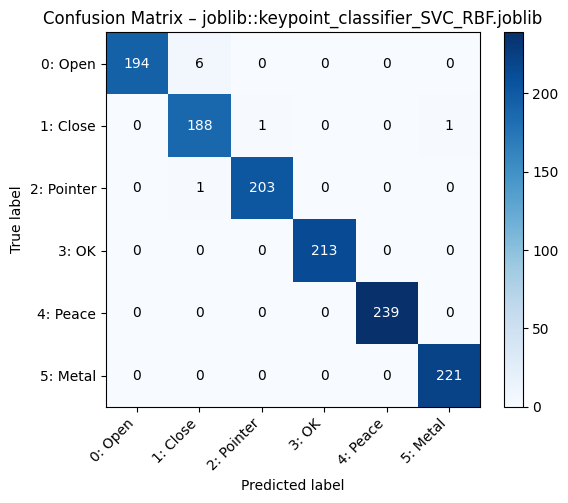

C:\Users\brian\AppData\Local\Temp\ipykernel_2956\1088246813.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


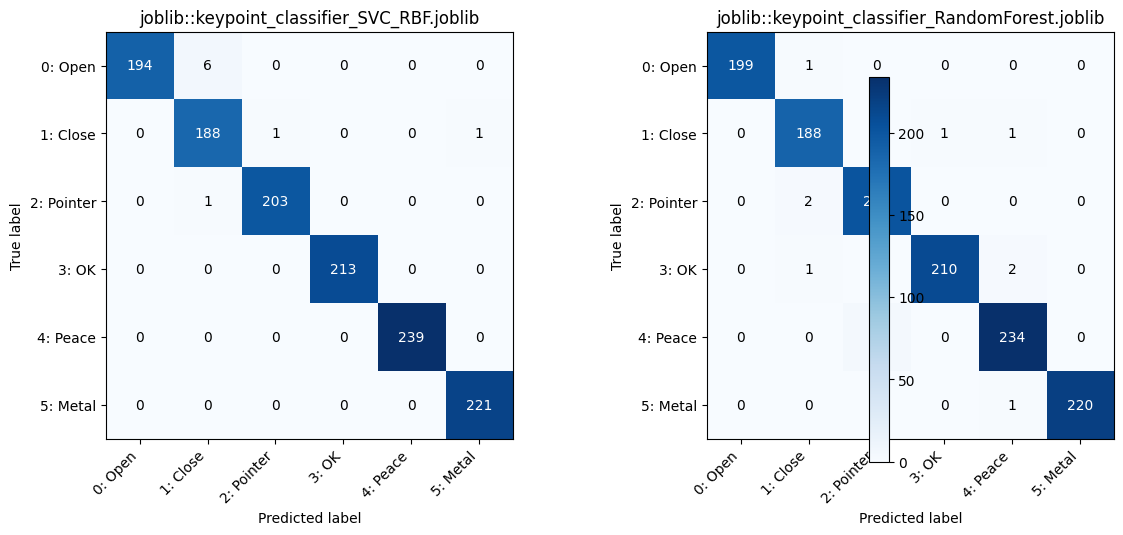

In [32]:
model_a = summary_df["model_name"].iloc[0]
model_b = summary_df["model_name"].iloc[1] if len(summary_df) > 1 else None

print(f"Model A: {model_a}")
print(f"Model B: {model_b}")

res_a = all_results[model_a]
plot_confusion_matrix(res_a["cm"], res_a["label_strings"], title=f"Confusion Matrix – {model_a}")

if model_b is not None:
    res_b = all_results[model_b]
    if np.array_equal(res_a["labels"], res_b["labels"]):
        plot_two_confusion_matrices(
            cm_a=res_a["cm"],
            labels_a=res_a["label_strings"],
            name_a=model_a,
            cm_b=res_b["cm"],
            labels_b=res_b["label_strings"],
            name_b=model_b,
        )
    else:
        print("Labels differ, skip side-by-side comparison.")


In [33]:
best_model_name = summary_df["model_name"].iloc[0]
y_true = all_results[best_model_name]["y_true"]
y_best = all_results[best_model_name]["y_pred"]

rows = []
for name, res in all_results.items():
    if name == best_model_name:
        continue
    y_pred = res["y_pred"]
    chi2_stat, p_value, b, c = mcnemars_test(y_true, y_best, y_pred)
    rows.append({
        "model_name": name,
        "vs_best_model": best_model_name,
        "chi2_stat": chi2_stat,
        "p_value": p_value,
        "b_best_correct_other_wrong": b,
        "c_best_wrong_other_correct": c,
        "significant_at_0.05": (p_value < 0.05) if not np.isnan(p_value) else np.nan,
    })

if rows:
    mcnemar_df = pd.DataFrame(rows).sort_values("p_value")
    print("📈 McNemar's test (difference vs best model):")
    display(mcnemar_df)
else:
    print("Only one model available — McNemar's test needs at least two.")


📈 McNemar's test (difference vs best model):


,model_name,vs_best_model,chi2_stat,p_value,b_best_correct_other_wrong,c_best_wrong_other_correct,significant_at_0.05
7,tflite::keypoint_classifier_transformer_self_attention.tflite,joblib::keypoint_classifier_SVC_RBF.joblib,332.026627,3.478478e-74,337,1,True
5,joblib::keypoint_classifier_xgboost_20251119_143921.joblib,joblib::keypoint_classifier_SVC_RBF.joblib,195.005076,2.569825e-44,197,0,True
2,joblib::keypoint_classifier_LogisticRegression.joblib,joblib::keypoint_classifier_SVC_RBF.joblib,186.005319,2.367725e-42,188,0,True
1,joblib::keypoint_classifier_LinearSVC.joblib,joblib::keypoint_classifier_SVC_RBF.joblib,180.005495,4.833043e-41,182,0,True
6,tflite::keypoint_classifier.tflite,joblib::keypoint_classifier_SVC_RBF.joblib,89.252525,3.474990e-21,97,2,True
4,joblib::keypoint_classifier_xgboost.joblib,joblib::keypoint_classifier_SVC_RBF.joblib,87.011236,1.079064e-20,89,0,True
0,joblib::keypoint_classifier_KNeighbors.joblib,joblib::keypoint_classifier_SVC_RBF.joblib,3.368421,6.645742e-02,14,5,False
3,joblib::keypoint_classifier_RandomForest.joblib,joblib::keypoint_classifier_SVC_RBF.joblib,1.066667,3.016996e-01,10,5,False


In [34]:
if SIMILAR_GESTURE_GROUP:
    focus_labels = [label_map.get(i, str(i)) for i in SIMILAR_GESTURE_GROUP]
    print(f"Similar gesture group: {SIMILAR_GESTURE_GROUP} -> {focus_labels}")
    res = all_results[summary_df["model_name"].iloc[0]]
    mask = np.isin(res["y_true"], SIMILAR_GESTURE_GROUP)
    if mask.sum() == 0:
        print("No samples from the configured similar gesture group in this dataset.")
    else:
        sim_df = pd.DataFrame({
            "true_id": res["y_true"][mask],
            "pred_id": res["y_pred"][mask],
        })
        sim_df["true_label"] = sim_df["true_id"].map(label_map)
        sim_df["pred_label"] = sim_df["pred_id"].map(label_map)

        pivot_counts = pd.crosstab(sim_df["true_label"], sim_df["pred_label"], dropna=False)
        pivot_rates = pivot_counts.div(pivot_counts.sum(axis=1), axis=0).fillna(0.0)

        print("Counts within the similar gesture subset:")
        display(pivot_counts)

        print("Row-normalized confusion (fractions):")
        display(pivot_rates)

        anchor_mask = sim_df["true_id"] == SIMILAR_ANCHOR
        allies = [c for c in SIMILAR_GESTURE_GROUP if c != SIMILAR_ANCHOR]
        if anchor_mask.sum() > 0:
            anchor_confusions = sim_df[anchor_mask & sim_df["pred_id"].isin(allies)]
            print(
                f"Pinch ({SIMILAR_ANCHOR}) misclassified as OK/Love: "
                f"{len(anchor_confusions)}/{anchor_mask.sum()} samples"
            )
            if not anchor_confusions.empty:
                display(anchor_confusions["pred_label"].value_counts().rename("count").to_frame())
        else:
            print("No Pinch samples found in this evaluation set.")
else:
    print("No similar gesture group configured.")


Similar gesture group: [3, 8, 9] -> ['OK', 'Pinch', 'Love']
Counts within the similar gesture subset:


pred_label,OK
true_label,
OK,213


Row-normalized confusion (fractions):


pred_label,OK
true_label,
OK,1.0


No Pinch samples found in this evaluation set.


## Notes & Next Steps

- Update `TRAINING_TIME_OVERRIDES` if you have ground-truth training durations (especially for the TFLite exports).
- Adjust `SIMILAR_GESTURE_GROUP`, `NOISE_STD` or `TOP_K` in the config cell to explore other scenarios.
- Re-run the notebook after training a new model – it will be automatically discovered inside `models/keypoint`.
